In [14]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
from statistics import mean, stdev
from math import sqrt
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px # Интерактивная библиотека для графиков.


warnings.filterwarnings('ignore')

Описание проекта

Cookie Cats - чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. Это классическая головоломка в стиле "соедини три", в которой игрок должен соединять плитки одного цвета, чтобы очистить игровое поле и пройти уровень.
По мере прохождения игры игроки будут сталкиваться с воротами, которые заставляют их ждать некоторое время, прежде чем они смогут прогрессировать или совершать покупки в приложении. В этом проекте мы проанализируем результат теста A / B, в котором первые ворота в Cookie Cats были перенесены с 30-го уровня на 40-й. В частности, мы проанализируем влияние на удержание игроков.


In [2]:
# Загружаем данные
df = pd.read_csv('cookie_cats.csv',sep=',')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
# Проверка пропущенных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. 

Переменные:

userid — уникальный номер, идентифицирующий каждого игрока.

версия - попал ли игрок в контрольную группу (gate_30) или группу с перенесенными воротами (gate_40).

sum_gamerounds — количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.

Retention_1 - вернулся ли игрок через 1 день после установки

Retention_7 - вернулся ли игрок через 7 день после установки

Когда игрок устанавливал игру, ему или ей случайным образом присваивалась версия 30 или 40. 

In [147]:
#Изучим наши данные

In [19]:
# Смотрим кол-во игроков в каждой группе
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


 В группах примерно одинаковое кол-во игроков

<AxesSubplot:>

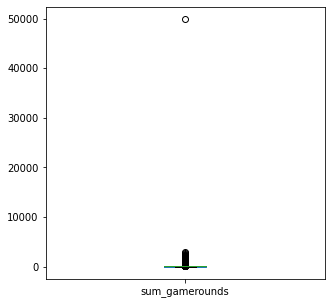

In [6]:
# Оценим сколько игровых раундов было сыграно игроком в течение первой недели после установки игры.
df['sum_gamerounds'].plot.box(figsize=(5,5))

In [7]:
# Выброс мешает объективной оценки
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

<AxesSubplot:>

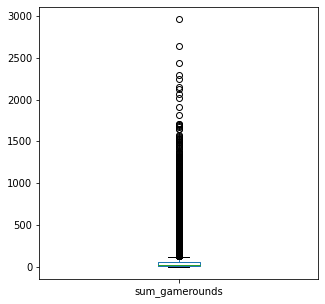

In [8]:
df.query('sum_gamerounds < 40000').sum_gamerounds.plot.box(figsize=(5,5))

In [137]:
df2 = df.query('sum_gamerounds < 40000')

In [9]:
sum_gamerounds = df.groupby('sum_gamerounds', as_index = False).agg({'userid':'count'}).rename(columns={'userid':'us_count'})
sum_gamerounds.head(10)

,sum_gamerounds,us_count
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [10]:
sum_gamerounds.tail(10)

,sum_gamerounds,us_count
932,2015,1
933,2063,1
934,2124,1
935,2156,1
936,2251,1
937,2294,1
938,2438,1
939,2640,1
940,2961,1
941,49854,1


In [26]:
gate_30_df = df[df["version"]=="gate_30"]
sum_count_30 = gate_30_df.userid.nunique()
sum_count_30

44700

Как видно половина пользователей останавливалась на 16 раундах, при этом почти четыре тысячи пользователей вообще не проходили игру

In [79]:
# Построим диаграмму воронки в процентах 

gate_30_df = df[df["version"]=="gate_30"]
gate_40_df = df[df["version"]=="gate_40"]


downloads_30_p = gate_30_df.userid.nunique()*100/gate_30_df.userid.nunique()
downloads_40_p = gate_40_df.userid.nunique()*100/gate_40_df.userid.nunique()

first_time_30_p = round(gate_30_df[gate_30_df["sum_gamerounds"]>0].userid.nunique()*100/gate_30_df.userid.nunique(), 3)
first_time_40_p = round(gate_30_df[gate_30_df["sum_gamerounds"]>0].userid.nunique()*100/gate_40_df.userid.nunique(), 3)

f_day_30_p = round(gate_30_df.retention_1.sum()*100/gate_30_df.userid.nunique(), 3)
f_day_40_p = round(gate_40_df.retention_1.sum()*100/gate_40_df.userid.nunique(), 3)

s_day_30_p = round(gate_30_df.retention_7.sum()*100/gate_30_df.userid.nunique(), 3)
s_day_40_p = round(gate_40_df.retention_7.sum()*100/gate_40_df.userid.nunique(), 3)
                  
data = dict(Quantity=[downloads_30_p, first_time_30_p, f_day_30_p, s_day_30_p, 
                      downloads_40_p, first_time_40_p, f_day_40_p, s_day_40_p],
    
            Stage=["Downloads", "First time", "1-day retention", "7-day retention"]*2,
    
            Version = ['gate_30']*4 + ['gate_40']*4)
                  
                  
stage = ["Downloads", "First time", "1-day retention", "7-day retention"]

fig = px.funnel(data, y='Stage', x='Quantity', color='Version',
                color_discrete_map={"Tatooine": "#374B53", 
                                    "Mandalore": "#617588"},
                template="simple_white",
                title='Диаграмма воронки',
                labels={"Stage": ""})
fig.show()


Мы уже проверили, что количество пользователей в разных группах, скачавших приложение, примерно одинаковое, поэтому нам достаточно информации о конверсии в процентах.
Можно отметить, что при этом есть разница в конверсиях между группами

Сыграли в игру хотя бы раз, после установки в случае группы gate_30 на 1,66 % пользователей больше
Разница между конверсией в первый день в двух группах составляет почти 0,6 %.
Разница между конверсией седьмого дня в двух группах составляет 0,82 %.

Осталось понять имеет ли эта разница значение.

<h4>A/B-тест

Существует несколько этапов, которые необходимо выполнить при проведении A/B-тестирования. В первую очередь, нужно сформулировать гипотезу, которую мы хотим проверить. Затем необходимо проверить контрольные предположения, чтобы убедиться в том, что наши данные соответствуют требованиям для проведения тестирования. После этого можно применять выбранную гипотезу и сравнивать результаты между контрольной и экспериментальной группами. Важно также учитывать статистические и продуктовые факторы, которые могут влиять на мощность теста и достоверность полученных результатов.

Выдвигаем гипотезы

H0: «Между «gate30» и «gate40» нет статистически значимой разницы».

H1: «Между «gate30» и «gate40» есть статистически значимая разница».

Перед проведением A/B теста необходимо проверить нормальность распределений

Проверим нормальность распределения

H0 = распределения метрик имеют нормальную форму

H1 = распределения метрик имеют ненормальную форму

In [140]:
# Создаем дф по контрольной и тестовой группе

control = df[df['version'] == 'gate_30']
test = df[df['version'] == 'gate_40']

In [111]:
control_t = control.query('retention_1==1').userid.count()

<h2>Retention

Для конверсионных типов метрик подходящим статистическим критериям является z-тест

In [139]:
#retention - 1

from statsmodels.stats.proportion import proportions_ztest
control_t = control['retention_1'].sum()
control_size = control.shape[0]
test_t = test['retention_1'].sum()
test_size = test.shape[0]

z_score, p_value = proportions_ztest(count=[control_t, control_size], nobs=[test_t, test_size], alternative='two-sided')

z_score, p_value

(13.530956414640618, 1.0267899061784413e-41)

In [141]:
#retention - 7

from statsmodels.stats.proportion import proportions_ztest
control_t = control['retention_7'].sum()
control_size = control.shape[0]
test_t = test['retention_7'].sum()
test_size = test.shape[0]

z_score, p_value = proportions_ztest(count=[control_t, control_size], nobs=[test_t, test_size], alternative='two-sided')

z_score, p_value

(36.311495190802, 1.0655409239186217e-288)

Так как pvalue < 0.05, мы отвергаем нулевую гипотезу об отсутсвии взаимосвязи

<h2> Количество игровых раундов

In [142]:
c_gr1 = stats.shapiro(df2.query('version == "gate_30"')['sum_gamerounds'].values)
c_gr2 = stats.shapiro(df2.query('version == "gate_40"')['sum_gamerounds'].values)
print('pvalue для группы 30 -', round(c_gr1[1], 4), 'pvalue для группы 40 -', round(c_gr2[1], 4))

pvalue для группы 30 - 0.0 pvalue для группы 40 - 0.0


Распределение сыгранных игровых раундов явно не является нормальным

Если распределение признака отличается от нормального, можно использовать непараметрический аналог – U-критерий Манна-Уитни. Он переводит все данные в ранговую шкалу (ранжирует показатели температуры от 1 до последнего), после этого считает какой средний ранг оказался в первой группе и какой во второй. Этот критерий менее чувствителен к экстремальным отклонениям от нормальности и наличию выбросов. которые как мы знаем, у нас есть

In [146]:
stats.mannwhitneyu(control['sum_gamerounds'], test['sum_gamerounds'], alternative='two-sided')

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

p_value > 0.05, а значит мы отвергаем нулевую гипотезу  - «Между «gate30» и «gate40» нет статистически значимой разницы».

<h4> Вывод
    
    Мы провели анализ данных в игре Cookie Cats Games, связанной с определением наилучшего места для размещения двери в игре. После анализа данных и переменных мы определили, что ворота 30 являются наиболее выгодным вариантом. Для подтверждения нашей гипотезы мы провели статистический анализ с использованием тестов Шапиро, Левена и U-критерия Манна-Уитни. Результаты показали, что статистически значимая разницы между двумя дверьми есть, и компании нужно продолжать использовать 
    Gate30.